In [1]:
#!/usr/bin/python
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from helper import predict_from_score, correlate, crt_plot, plt_precision_recall_vs_threshold, plt_precision_vs_recall, plot_roc_curve 
import sys
import pickle
sys.path.append("../tools/")

from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

IMAGES = '../images/'
DATA   = '../data/'

----

In [2]:
#############################
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features
payment_features = ['salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments', 'other', 'expenses', 'director_fees', 'total_payments']
stock_features   = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']
mail_features    = ['from_this_person_to_poi', 'from_poi_to_this_person', 'shared_receipt_with_poi']
extra_features   = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate',
                    'toPOI_rate', 'fromPOI_rate']
extra_finance    = ['bonus_deferral_payments_rate', 'rest_stock_deferral_payments_rate', 'exer_stock_options_deferral_payments_rate',
                    'long_term_incentive_total_payments_rate', 'bonus_total_payments_rate', 'exer_stock_options_total_payments_rate']
extra_mail       = ['toPOI_rate', 'fromPOI_rate']
feature_list = payment_features + stock_features + mail_features + extra_features

In [3]:
### Load the dictionary containing the dataset
my_data = pd.read_pickle(DATA+"my_dataFrame.pkl")
# Divide data into features and labels 
y = my_data['poi'].copy().astype(np.uint8)
X = my_data[feature_list].copy()
# Split data into training and test set using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=77, stratify=y) 

----

In [4]:
# I spare 30% of the data as test set to have at least 5 'poi's in the test set. It's important to me to realize a high recall value, identifying as many 'poi's as possible.  
print "Number of POIs in the test set:" , y_test.sum()

Number of POIs in the test set: 6


In [5]:
# Save the order of insiders
insiders_train = y_train.index
insiders_test  = y_test.index

In [6]:
# Dealing with missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Imputation Stategies

In [7]:
# I'd like to explore different strategies filling NAN values
# Imputer_01:
# Applies median to mail and extra NAN features and 0 to financial NAN features
impute_01 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='median'), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer_02:
# Applies median to all NAN features 
impute_02 = SimpleImputer(strategy='median')
# Imputer_03:
# Applies 0.0 to all NAN features
impute_03 = SimpleImputer(strategy='constant', fill_value=0.0)
# Imputer 04
# Applies 0.0 to financial and extra_finance featurtes and median to 'mail_features' and 'extra_mail'
impute_04 = ColumnTransformer(
     [('finance_data',  SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), payment_features+stock_features),
      ('mail_data',     SimpleImputer(missing_values=np.nan, strategy='median'), mail_features),
      ('extra_finance', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0), extra_finance),
      ('extra_mail',    SimpleImputer(missing_values=np.nan, strategy='median'), extra_mail)],
     remainder='passthrough')
# Imputer 05
# Applies mean values to all NAN
impute_05 = SimpleImputer(strategy='mean')
imputers = [impute_01, impute_02, impute_03, impute_04, impute_05]

### Scaling strategies

In [8]:
# Define different scaling strategies
no_scl     = FunctionTransformer(func=lambda x: np.array(x))
robust_scl = RobustScaler()
std_scl    = StandardScaler()
power_scl  = PowerTransformer(method='yeo-johnson')
scalers = [no_scl, robust_scl, std_scl, power_scl]
scaler_names = ['NO SCALING', 'ROBUST SCALER', 'STANDARD SCALER', 'POWER SCALER']

----

### The most promising models

In [10]:
from sklearn.linear_model import SGDClassifier  

In [11]:
SGD_clf = SGDClassifier(random_state=77)

In [12]:
from sklearn import svm

In [13]:
svm_clf = svm.SVC(gamma='auto')

In [14]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier

In [15]:
RF_clf = RandomForestClassifier(random_state=77, n_estimators=100, bootstrap=True)

In [16]:
classifiers = [ svm_clf, RF_clf, SGD_clf]

In [18]:
clf_names = [ 'SVC', 'Rand. Forest', 'SGD']

In [21]:
# Build pipelines for imputation and scaling
pipe_41 = Pipeline([ ('impute_04', impute_04), ('scale', no_scl) ])
pipe_44 = Pipeline([ ('impute_04', impute_04), ('scale', power_scl) ])

X_train_41 = pipe_41.fit_transform(X_train)
X_train_44 = pipe_44.fit_transform(X_train);

----

## Feature selection

### Try different sets of features and check the impact on the results (ROC AUC)

In [151]:
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate

In [152]:
svm_clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [153]:
y_scores = cross_val_predict(svm_clf, X_train_44, y_train, cv=10, method='decision_function' )

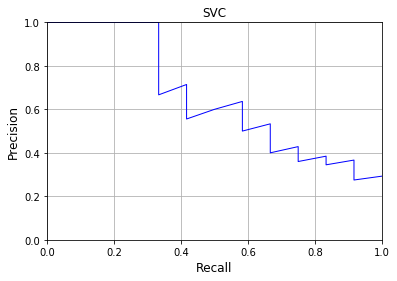

In [154]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [155]:
y_pred = predict_from_score(y_train, y_scores, 0.9, 0.3, verbose=1)

Realized metric values:
Recall: 0.9166666666666666
Precision: 0.36666666666666664
Probability/ decision function: -0.9314159592340644
Index: 11


In [156]:
confusion_matrix(y_train, y_pred)

array([[69, 19],
       [ 1, 11]], dtype=int64)

In [157]:
roc_auc_score(y_train, y_scores)

0.9119318181818181

In [158]:
X_train_44_df = pd.DataFrame(X_train_44, columns=feature_list)

In [159]:
y_scores = cross_val_predict(svm_clf, X_train_44_df.loc[:, payment_features+stock_features+extra_mail], y_train, cv=10, method='decision_function' )

In [160]:
roc_auc_score(y_train, y_scores)

0.9422348484848485

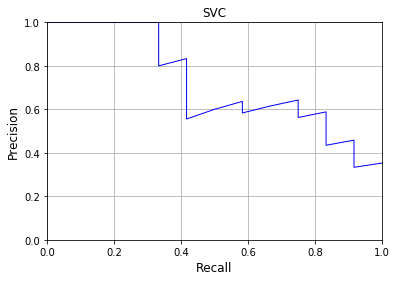

In [161]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

----

#### Feature reduction

##### Variance Threshold

In [41]:
from sklearn.feature_selection import VarianceThreshold

In [42]:
varianceThreshold = VarianceThreshold()

In [43]:
varianceThreshold.fit(X_train_44)

VarianceThreshold(threshold=0.0)

In [45]:
varianceThreshold.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [51]:
varianceThreshold.variances_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [46]:
# Seems that all features are important

##### SelectKBest and SelectPercentile

In [162]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, SelectFdr, SelectFpr

In [171]:
KBest = SelectKBest(k=24 )

In [173]:
X_train_44_red = KBest.fit_transform(X_train_44, y_train)

In [174]:
KBest_scores_df = pd.DataFrame(KBest.scores_, index=feature_list)

In [175]:
KBest_scores_df.sort_values(0, ascending=False)

,0
toPOI_rate,16.262856
total_stock_value,14.241934
bonus_total_payments_rate,11.526630
expenses,10.429717
bonus,10.375911
other,10.141966
long_term_incentive,8.855082
total_payments,8.432336
restricted_stock,7.226538
salary,7.109366


In [184]:
y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function' )

In [185]:
roc_auc_score(y_train, y_scores)

0.9119318181818181

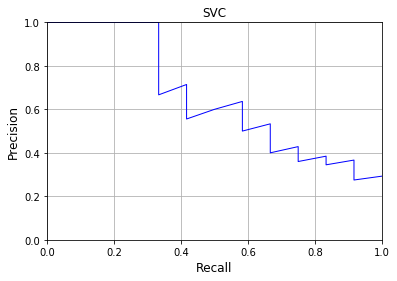

In [186]:
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC')

In [190]:
for n in range(1, len(feature_list)+1):
    KBest = SelectKBest(k=n)
    X_train_44_red = KBest.fit_transform(X_train_44, y_train)
    y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function')
    print roc_auc_score(y_train, y_scores), "ROC AUC for", n, "features."

0.6017992424242424 ROC AUC for 1 features.
0.4981060606060606 ROC AUC for 2 features.
0.6856060606060606 ROC AUC for 3 features.
0.7973484848484849 ROC AUC for 4 features.
0.7935606060606061 ROC AUC for 5 features.
0.8418560606060606 ROC AUC for 6 features.
0.8721590909090909 ROC AUC for 7 features.
0.8892045454545454 ROC AUC for 8 features.
0.8901515151515151 ROC AUC for 9 features.
0.8882575757575757 ROC AUC for 10 features.
0.8172348484848484 ROC AUC for 11 features.
0.8380681818181819 ROC AUC for 12 features.
0.8304924242424242 ROC AUC for 13 features.
0.8513257575757576 ROC AUC for 14 features.
0.8655303030303031 ROC AUC for 15 features.
0.8731060606060607 ROC AUC for 16 features.
0.9090909090909092 ROC AUC for 17 features.
0.8977272727272727 ROC AUC for 18 features.
0.9242424242424242 ROC AUC for 19 features.
0.9147727272727273 ROC AUC for 20 features.
0.9299242424242424 ROC AUC for 21 features.
0.9308712121212122 ROC AUC for 22 features.
0.9223484848484849 ROC AUC for 23 feature

##### RFE and RFECV

In [233]:
from sklearn.feature_selection import RFE, RFECV

In [194]:
SVC_lin = svm.SVC(gamma='auto', kernel='linear')

In [196]:
RFE_ = RFE(SVC_lin).fit(X_train_44, y_train)

In [201]:
RFE_.ranking_

array([ 1,  1,  6,  1,  3,  2,  1, 13,  9,  1, 10,  5,  1,  8, 11,  1,  1,
        1,  1,  4,  7,  1,  1, 12])

In [202]:
RFE_.get_support()

array([ True,  True, False,  True, False, False,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False, False,  True,  True, False])

In [204]:
y_scores = cross_val_predict(svm_clf, X_train_44[:,RFE_.get_support()], y_train, cv=10, method='decision_function' )

In [205]:
roc_auc_score(y_train, y_scores)

0.9412878787878789

In [207]:
for n in range(1, len(feature_list)+1):
    X_train_44_red = RFE(SVC_lin, n_features_to_select=n).fit_transform(X_train_44, y_train)
    y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function')
    print roc_auc_score(y_train, y_scores), "ROC AUC for", n, "features."

0.7206439393939393 ROC AUC for 1 features.
0.4204545454545454 ROC AUC for 2 features.
0.6695075757575758 ROC AUC for 3 features.
0.9270833333333334 ROC AUC for 4 features.
0.9535984848484849 ROC AUC for 5 features.
0.9460227272727272 ROC AUC for 6 features.
0.9422348484848484 ROC AUC for 7 features.
0.9375 ROC AUC for 8 features.
0.9337121212121212 ROC AUC for 9 features.
0.9422348484848484 ROC AUC for 10 features.
0.9356060606060607 ROC AUC for 11 features.
0.9412878787878789 ROC AUC for 12 features.
0.9318181818181818 ROC AUC for 13 features.
0.9318181818181818 ROC AUC for 14 features.
0.9431818181818181 ROC AUC for 15 features.
0.9318181818181818 ROC AUC for 16 features.
0.928030303030303 ROC AUC for 17 features.
0.928030303030303 ROC AUC for 18 features.
0.9109848484848485 ROC AUC for 19 features.
0.9081439393939393 ROC AUC for 20 features.
0.9147727272727272 ROC AUC for 21 features.
0.9204545454545454 ROC AUC for 22 features.
0.915719696969697 ROC AUC for 23 features.
0.9119318181

0.9535984848484849 ROC AUC for


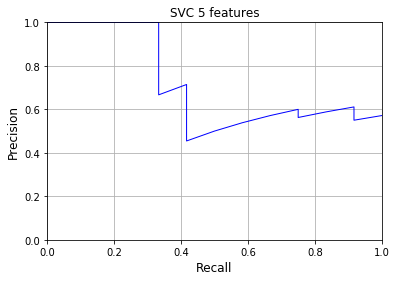

In [236]:
# 5 features leading to highest ROC
RFE_5 = RFE(SVC_lin, n_features_to_select=5).fit(X_train_44, y_train)
X_train_44_red = RFE_5.transform(X_train_44)
y_scores = cross_val_predict(svm_clf, X_train_44_red, y_train, cv=10, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC 5 features')

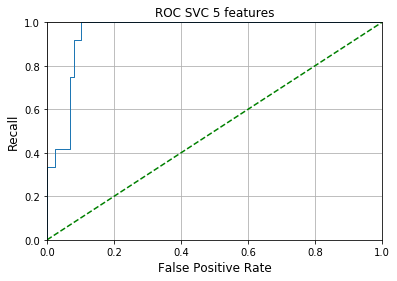

In [209]:
fpr, tpr, thresh = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr, title='ROC SVC 5 features')

In [219]:
RFE_1 = RFE(SVC_lin, n_features_to_select=1).fit(X_train_44, y_train)

In [220]:
RFE_1.ranking_

array([11,  5, 17,  9, 14, 13,  1, 24, 20,  3, 21, 16,  2, 19, 22, 10,  8,
        7,  6, 15, 18, 12,  4, 23])

In [225]:
score_table = pd.DataFrame(zip(X_train_44_df.columns.to_list(), RFE_1.ranking_))

In [232]:
score_table.sort_values(1, ascending=True)

,0,1
6,expenses,1
12,total_stock_value,2
9,exercised_stock_options,3
22,toPOI_rate,4
1,bonus,5
18,exer_stock_options_deferral_payments_rate,6
17,rest_stock_deferral_payments_rate,7
16,bonus_deferral_payments_rate,8
3,deferred_income,9
15,shared_receipt_with_poi,10


In [273]:
RFECV_ = RFECV(SVC_lin, cv=10, min_features_to_select=1).fit(X_train_44,y_train)

In [274]:
RFECV_.ranking_

array([ 1,  1,  5,  1,  2,  1,  1, 12,  8,  1,  9,  4,  1,  7, 10,  1,  1,
        1,  1,  3,  6,  1,  1, 11])

In [275]:
RFECV_.support_

array([ True,  True, False,  True, False,  True,  True, False, False,
        True, False, False,  True, False, False,  True,  True,  True,
        True, False, False,  True,  True, False])

0.9318181818181818 ROC AUC for


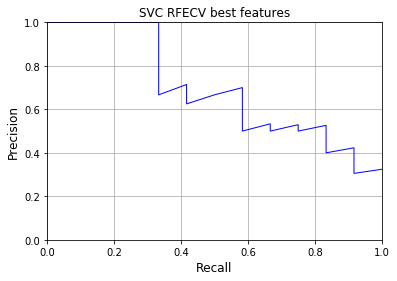

In [282]:
# RFECV features reduction. RFB Kernel results.
y_scores = cross_val_predict(svm_clf, X_train_44[:,RFECV_.support_], y_train, cv=10, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC RFECV best features')

In [277]:
score_table = pd.DataFrame(zip(feature_list, RFECV_.ranking_))
score_table.sort_values(1, ascending=True)

,0,1
0,salary,1
1,bonus,1
21,exer_stock_options_total_payments_rate,1
3,deferred_income,1
5,other,1
6,expenses,1
18,exer_stock_options_deferral_payments_rate,1
9,exercised_stock_options,1
17,rest_stock_deferral_payments_rate,1
22,toPOI_rate,1


0.9356060606060606 ROC AUC for


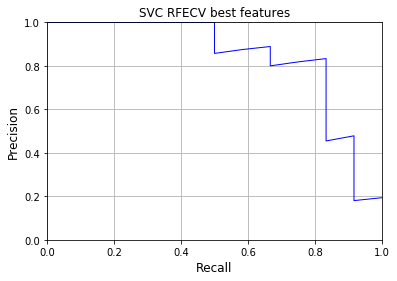

In [280]:
# RFECV features reduction. Linear Model results.
y_scores = cross_val_predict(SVC_lin, X_train_44[:,RFECV_.support_], y_train, cv=10, method='decision_function')
print roc_auc_score(y_train, y_scores), "ROC AUC for"
precision, recall, proba = precision_recall_curve(y_train, y_scores)
plt_precision_vs_recall(precision, recall, title='SVC RFECV best features')

----

In [54]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

In [55]:
# Example starting point. Try investigating other evaluation techniques!
from sklearn.cross_validation import train_test_split
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

ImportError: No module named cross_validation

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
'''

In [217]:
X_train_44_df.loc[:,RFE_5.support_].columns

Index([u'bonus', u'expenses', u'exercised_stock_options', u'total_stock_value',
       u'toPOI_rate'],
      dtype='object')